[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/your-repo/CIFAR10_FFNN_Lab.ipynb)

> Click to launch in Google Colab. In Colab: **Runtime → Change runtime type → GPU**.

# Image Classification (CIFAR‑10) with a Convolutional Neural Network: Training Dynamics & Evaluation


**Weighting (Total 5%)**
- **In‑Lab (3 hours):**
  - A1: Pipeline working on subset, with logs/curves (1.0%)
  - A2: Architecture is correct (no flatten at input), shapes verified basic accuracy target met (0.8%)
  - A3: Clean code & brief in lab notes (0.2%)
  - A4: Save and load model checkpoints (NOT graded, but recommended)

- **Take‑Home (1 week):**
  - B1: Full data training + ≥2 augmentations, settings documented (1.0%)
  - B2: Results quality (within reasonable band for your setup) + clear plots/tables (1.0%)
  - B3: Fair comparison to A2 with thoughtful discussion (0.7%)
  - B4: Reproducibility (seeds, README, runtime notes) (0.3%)

**Learning goals**

By the end of this assignment, you should be able to:
- Explain why CNNs do not flatten the image at the input and how spatial structure is preserved layer to layer.
- Implement a compact CNN (Conv→ReLU→Pool stacks; optional BatchNorm/Dropout) and train it on CIFAR 10.
- Use common augmentations (random crop/flip/colour jitter/cutout) and discuss their impact on generalization.
- Run a fair comparison against a fully connected baseline (from A2) using matched training setups and report metrics clearly.

**Instructions**: Run cells top‑to‑bottom. For the take‑home, edit the designated section and keep your changes minimal but clear.

In [1]:
# ✅ Device setup (CPU/GPU)
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

from collections.abc import Mapping, Sequence
def to_device(obj, device=device):
    if hasattr(obj, 'to'):
        try:
            return obj.to(device)
        except Exception:
            return obj
    if isinstance(obj, Mapping):
        return obj.__class__({k: to_device(v, device) for k, v in obj.items()})
    if isinstance(obj, Sequence) and not isinstance(obj, (str, bytes)):
        return obj.__class__([to_device(v, device) for v in obj])
    return obj

Using device: cuda


Importing some required libraries. You can add more if needed.

In [2]:
# import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import torch.nn as nn
import torch.optim as optim
import time
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm


## Part A: Model, Training Loop, and Curves (In‑Lab)

## Part A: Data Loading & Normalization

In [3]:
n_epochs = 10
learning_rate = 1e-3
log_interval = 50
random_seed = 1

torch.manual_seed(random_seed)

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np

# Load the CIFAR-10 dataset
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)
train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

# DataLoader definitions
root = './data'
full_train = datasets.CIFAR10(root, train=True, download=True, transform=train_tf)
test_ds    = datasets.CIFAR10(root, train=False, download=True, transform=test_tf)

val_size = 5000
train_size = len(full_train) - val_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)

(45000, 5000, 10000)

In [5]:
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        # Conv Block 1: 3 -> 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Conv Block 2: 32 -> 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Conv Block 3: 64 -> 128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

        # Fully connected layer
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        # Block 1: Conv -> BN -> ReLU -> MaxPool
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Block 2: Conv -> BN -> ReLU -> MaxPool
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Block 3: Conv -> BN -> ReLU -> Global Avg Pool
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.adaptive_avg_pool2d(x, (1, 1))

        # Flatten
        x = x.view(x.size(0), -1)

        # Dropout and FC
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [6]:
net_model = CIFAR10_CNN().to(device)
optimizer = optim.Adam(net_model.parameters(), lr=learning_rate)

In [7]:
def train(epoch, data_loader, model, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(data_loader.dataset),100. * batch_idx / len(data_loader), loss.item()))

In [8]:
def eval(data_loader, model, dataset):
    model.eval()
    loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            loss += F.cross_entropy(output, target, reduction='sum').item()

    loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)

    # Convert to Python float if it's a tensor
    if isinstance(accuracy, torch.Tensor):
        accuracy = accuracy.item()

    print('{} set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(dataset, loss, correct, len(data_loader.dataset), accuracy))

    return loss, accuracy

In [9]:
def overfit_check(model, train_loader, device, num_samples=128, epochs=100):
    """
    Overfit to a tiny batch (e.g., 128 images) to confirm the training loop works.
    """
    print(f"\n{'='*60}")
    print(f"SANITY CHECK: Overfitting to {num_samples} samples")
    print(f"{'='*60}")

    # Get a small batch
    dataiter = iter(train_loader)
    data, target = next(dataiter)
    data, target = data[:num_samples].to(device), target[:num_samples].to(device)

    # Create fresh model
    sanity_model = CIFAR10_CNN().to(device)
    sanity_optimizer = optim.Adam(sanity_model.parameters(), lr=learning_rate)

    sanity_model.train()
    for epoch in range(epochs):
        sanity_optimizer.zero_grad()
        output = sanity_model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        sanity_optimizer.step()

        pred = output.data.max(1, keepdim=True)[1]
        correct = pred.eq(target.data.view_as(pred)).sum()
        acc = 100. * correct / num_samples

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} - Acc: {acc:.2f}%")

    if acc > 95:
        print("PASS: Model can overfit (accuracy > 95%)")
    else:
        print("WARNING: Model struggles to overfit")
    print(f"{'='*60}\n")

def verify_tensor_shapes(model, device):
    """
    Verify tensor shapes after each layer (no flatten at input!)
    """
    print(f"\n{'='*60}")
    print("SHAPE VERIFICATION")
    print(f"{'='*60}")

    model.eval()
    x = torch.randn(1, 3, 32, 32).to(device)
    print(f"Input shape: {x.shape}")

    # Block 1
    x = F.relu(model.bn1(model.conv1(x)))
    print(f"After conv1 + bn1 + relu: {x.shape}")
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    print(f"After pool1: {x.shape}")

    # Block 2
    x = F.relu(model.bn2(model.conv2(x)))
    print(f"After conv2 + bn2 + relu: {x.shape}")
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    print(f"After pool2: {x.shape}")

    # Block 3
    x = F.relu(model.bn3(model.conv3(x)))
    print(f"After conv3 + bn3 + relu: {x.shape}")
    x = F.adaptive_avg_pool2d(x, (1, 1))
    print(f"After global avg pool: {x.shape}")

    # Flatten and FC
    x = x.view(x.size(0), -1)
    print(f"After flatten: {x.shape}")
    x = model.fc(x)
    print(f"Output shape: {x.shape}")

    print("All shapes look correct!")
    print(f"{'='*60}\n")

In [10]:
def train_with_history(model, train_loader, validation_loader, optimizer, n_epochs):
    """
    Train model and track metrics
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    print(f"\n{'='*60}")
    print(f"Training for {n_epochs} epochs with LR={learning_rate}")
    print(f"{'='*60}\n")

    for epoch in range(1, n_epochs + 1):
        # Train
        train(epoch, train_loader, model, optimizer)

        # Evaluate on training set (for tracking)
        train_loss, train_acc = eval(train_loader, model, "Training")

        # Evaluate on validation set
        val_loss, val_acc = eval(validation_loader, model, "Validation")

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

    return history

In [11]:
def plot_training_curves(history):
    """
    Plot loss and accuracy curves
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-s', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'b-o', label='Train Acc', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-s', label='Val Acc', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [12]:
def show_predictions(model, test_loader, device, num_samples=10):
    """
    Show example predictions
    """
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images[:num_samples].to(device), labels[:num_samples]

    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)

    # Move to CPU for plotting
    images = images.cpu()
    predicted = predicted.cpu()

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    # Unnormalize for display
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)

    for idx in range(num_samples):
        img = images[idx] * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0).numpy()

        axes[idx].imshow(img)
        axes[idx].axis('off')

        true_label = class_names[labels[idx]]
        pred_label = class_names[predicted[idx]]
        color = 'green' if labels[idx] == predicted[idx] else 'red'

        axes[idx].set_title(f'True: {true_label}\nPred: {pred_label}',
                           color=color, fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('example_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()


CIFAR-10 CNN TRAINING PIPELINE - PART A

SHAPE VERIFICATION
Input shape: torch.Size([1, 3, 32, 32])
After conv1 + bn1 + relu: torch.Size([1, 32, 32, 32])
After pool1: torch.Size([1, 32, 16, 16])
After conv2 + bn2 + relu: torch.Size([1, 64, 16, 16])
After pool2: torch.Size([1, 64, 8, 8])
After conv3 + bn3 + relu: torch.Size([1, 128, 8, 8])
After global avg pool: torch.Size([1, 128, 1, 1])
After flatten: torch.Size([1, 128])
Output shape: torch.Size([1, 10])
All shapes look correct!


SANITY CHECK: Overfitting to 128 samples
Epoch 10/100 - Loss: 1.7042 - Acc: 42.19%
Epoch 20/100 - Loss: 1.4209 - Acc: 56.25%
Epoch 30/100 - Loss: 1.1631 - Acc: 65.62%
Epoch 40/100 - Loss: 0.9114 - Acc: 79.69%
Epoch 50/100 - Loss: 0.6816 - Acc: 91.41%
Epoch 60/100 - Loss: 0.4951 - Acc: 97.66%
Epoch 70/100 - Loss: 0.3406 - Acc: 97.66%
Epoch 80/100 - Loss: 0.2016 - Acc: 100.00%
Epoch 90/100 - Loss: 0.1366 - Acc: 100.00%
Epoch 100/100 - Loss: 0.1025 - Acc: 100.00%
PASS: Model can overfit (accuracy > 95%)

Init

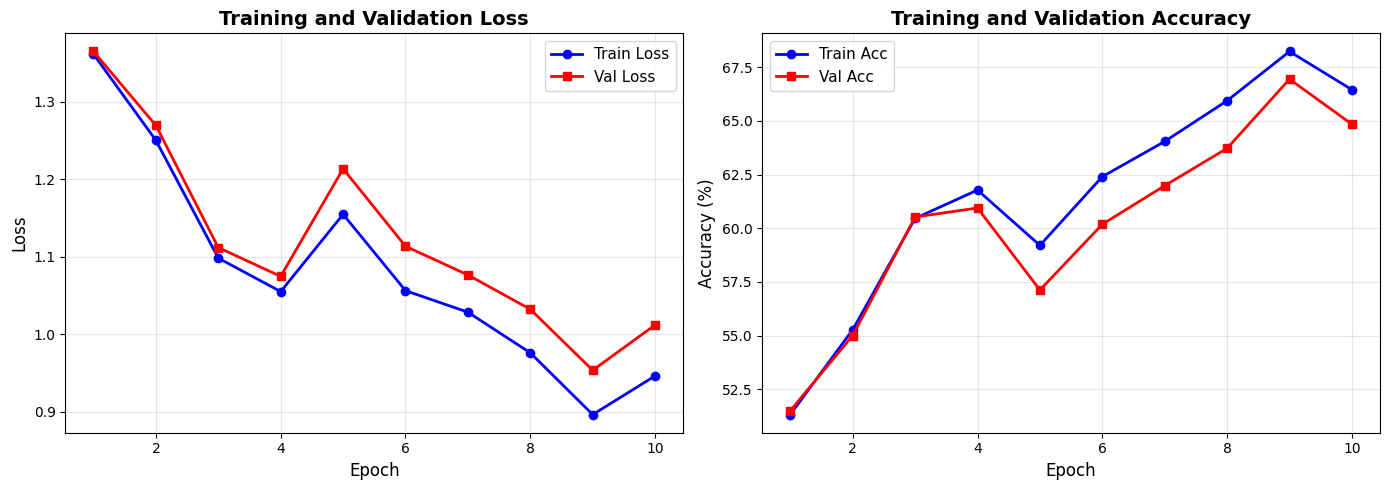

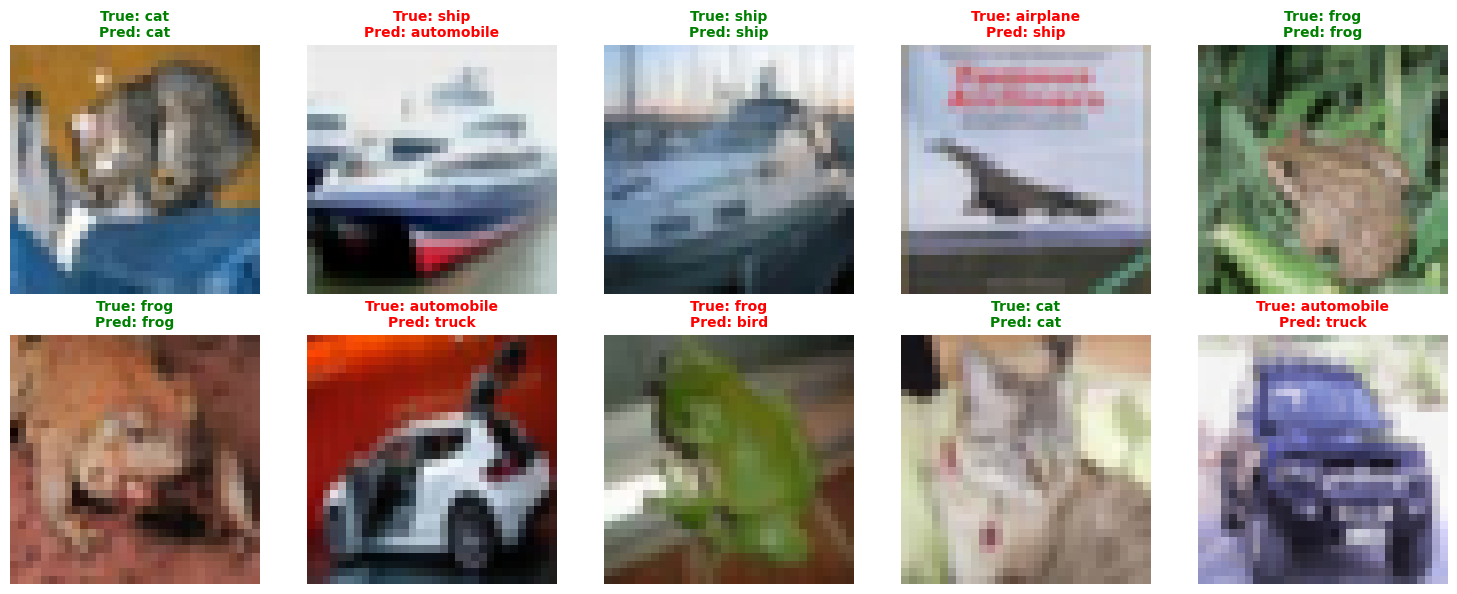


FINAL METRICS SUMMARY
Final Training Accuracy:   66.45%
Final Validation Accuracy: 64.84%
Final Test Accuracy:       63.73%



In [13]:
print("\n" + "="*70)
print("CIFAR-10 CNN TRAINING PIPELINE - PART A")
print("="*70)

# Sanity Checks
verify_tensor_shapes(net_model, device)
overfit_check(net_model, train_loader, device)

# Full training (re-initialize model)
print("Initializing fresh model for full training...")
net_model = CIFAR10_CNN().to(device)
optimizer = optim.Adam(net_model.parameters(), lr=learning_rate)

# Initial evaluation
print("Initial performance (before training):")
eval(val_loader, net_model, "Validation")

# Train with history tracking
history = train_with_history(net_model, train_loader, val_loader, optimizer, n_epochs)

# Final evaluation
test_loss, test_acc = eval(test_loader, net_model, "Test")
plot_training_curves(history)
show_predictions(net_model, test_loader, device)


print(f"\n{'='*70}")
print("FINAL METRICS SUMMARY")
print(f"{'='*70}")
print(f"Final Training Accuracy:   {history['train_acc'][-1]:.2f}%")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
print(f"Final Test Accuracy:       {test_acc:.2f}%")
# print(f"Total Parameters:          {total_params:,}")
print(f"{'='*70}\n")

## Part A: Save and load model checkpoints (NOT graded, but recommended)

In [ ]:
## YOUR CODE GOES HERE

## PART B: Take Home

#### **Goal:** Train on full CIFAR 10 with augmentations, tune modestly, and compare to your A2 fully connected NN.

In [4]:
n_epochs = 30
learning_rate = 1e-3
weight_decay = 5e-4  # L2 regularization
log_interval = 100
# log_interval = 50
random_seed = 1

torch.manual_seed(random_seed)

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


1. **Required augmentations (choose ≥2):**
- RandomCrop(32, padding=4)
- RandomHorizontalFlip()
- ColorJitter (mild)
- RandomErasing / Cutout (small holes)

Describe each choice and its expected effect.


In [5]:
print("\n" + "="*70)
print("PART B: DATA AUGMENTATION")
print("="*70)
print("\nChosen Augmentations (3 selected):")
print("\n1. RandomCrop(32, padding=4)")
print("   - Effect: Adds translation invariance")
print("   - Randomly shifts image by up to 4 pixels in any direction")
print("   - Helps model learn features regardless of position")
print("\n2. RandomHorizontalFlip(p=0.5)")
print("   - Effect: Adds horizontal reflection invariance")
print("   - 50% chance to flip image left-right")
print("   - Useful for CIFAR-10 (airplane, car, ship look similar flipped)")
print("\n3. ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)")
print("   - Effect: Adds lighting/color robustness")
print("   - Randomly adjusts brightness, contrast, and saturation")
print("   - Helps model handle different lighting conditions")
print("="*70 + "\n")

# CIFAR-10 normalization constants
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)

# Training transforms WITH augmentation
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Augmentation 1
    transforms.RandomHorizontalFlip(),      # Augmentation 2
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Augmentation 3
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

# Validation / Test transforms WITHOUT augmentation (only normalize)
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

# DataLoader definitions
root = './data'
full_train = datasets.CIFAR10(root, train=True, download=True, transform=train_tf)
test_ds    = datasets.CIFAR10(root, train=False, download=True, transform=test_tf)

val_size = 5000
train_size = len(full_train) - val_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

batch_size = 256
batch_size_train = 128
train_loader = DataLoader(train_ds, batch_size=batch_size_train, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")


PART B: DATA AUGMENTATION

Chosen Augmentations (3 selected):

1. RandomCrop(32, padding=4)
   - Effect: Adds translation invariance
   - Randomly shifts image by up to 4 pixels in any direction
   - Helps model learn features regardless of position

2. RandomHorizontalFlip(p=0.5)
   - Effect: Adds horizontal reflection invariance
   - 50% chance to flip image left-right
   - Useful for CIFAR-10 (airplane, car, ship look similar flipped)

3. ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
   - Effect: Adds lighting/color robustness
   - Randomly adjusts brightness, contrast, and saturation
   - Helps model handle different lighting conditions

Training samples: 45000
Validation samples: 5000
Test samples: 10000


2. **Training protocol:**
- Epochs: 30–60 (pick and justify); **Optimizer:** Adam or SGD+Momentum.
- LR schedule: optional StepLR or CosineAnnealing. State settings.
- Regularization: optional weight decay (e.g., 5e 4). Track training time & best epoch.
- Validation: hold out 5k images from training as validation (or use test set only for final report—be explicit and consistent).
- **Save the best performing model.**


In [6]:
class CIFAR10_CNN_Improved(nn.Module):
    """
    Improved CNN for Part B with better architecture
    """
    def __init__(self):
        super(CIFAR10_CNN_Improved, self).__init__()

        # Conv Block 1: 3 -> 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        # Conv Block 2: 64 -> 128
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # Conv Block 3: 128 -> 256
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Conv Block 4: 256 -> 256 (additional layer)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer
        self.fc = nn.Linear(256, 10)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 32x32 -> 16x16

        # Block 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 16x16 -> 8x8

        # Block 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 8x8 -> 4x4

        # Block 4 (no pooling)
        x = F.relu(self.bn4(self.conv4(x)))

        # Global Average Pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)

        # Dropout and FC
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [7]:
net_model = CIFAR10_CNN_Improved().to(device)
optimizer = optim.Adam(net_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning Rate Scheduler - Cosine Annealing
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-6)

# Mixed Precision Training - GradScaler for faster training
scaler = torch.amp.GradScaler()

In [8]:
def train(epoch, data_loader, model, optimizer, scheduler, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass
        with torch.amp.autocast('cuda'):
            output = model(data)
            loss = F.cross_entropy(output, target)

        # Mixed precision backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # output = model(data)
        # loss = F.cross_entropy(output, target)
        # loss.backward()
        # optimizer.step()

        running_loss += loss.item() * data.size(0)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum().item()
        total += target.size(0)

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLR: {:.6f}'.format(epoch, batch_idx * len(data), len(data_loader.dataset),100. * batch_idx / len(data_loader), loss.item(),optimizer.param_groups[0]['lr']))

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

In [9]:
def eval(data_loader, model, dataset):
    model.eval()
    loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            loss += F.cross_entropy(output, target, reduction='sum').item()

    loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)

    # Convert to Python float if it's a tensor
    if isinstance(accuracy, torch.Tensor):
        accuracy = accuracy.item()

    print('{} set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(dataset, loss, correct, len(data_loader.dataset), accuracy))

    return loss, accuracy


In [10]:
def train_with_history(model, train_loader, validation_loader, optimizer, scheduler, n_epochs, scaler):
    """
    Train model and track metrics
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    best_val_acc = 0.0
    best_epoch = 0
    start_time = time.time()

    print(f"\n{'='*70}")
    print(f"Starting Training - Part B")
    print(f"{'='*70}\n")

    for epoch in range(1, n_epochs + 1):
        epoch_start = time.time()

        # Train
        train_loss, train_acc = train(epoch, train_loader, model, optimizer, scheduler, scaler)

        if torch.isnan(torch.tensor(train_loss)):
          print("Training stopped due to NaN. Returning results up to this point.")
          break

        # Evaluate on validation set
        val_loss, val_acc = eval(validation_loader, model, "Validation")

        # Step the scheduler
        scheduler.step()

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch

        epoch_time = time.time() - epoch_start

        print(f"Epoch {epoch}/{n_epochs} completed in {epoch_time:.2f}s")
        print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
        print(f"Best Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch})")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 70 + "\n")

    total_time = time.time() - start_time

    print(f"{'='*70}")
    print(f"Training Complete!")
    print(f"Total training time: {total_time/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")
    print(f"{'='*70}\n")

    return history, best_val_acc, best_epoch, total_time

In [11]:
def plot_training_curves(history):
    """
    Plot loss and accuracy curves
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-s', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'b-o', label='Train Acc', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-s', label='Val Acc', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [12]:
def show_predictions(model, test_loader, device, num_samples=10):
    """
    Show example predictions
    """
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images[:num_samples].to(device), labels[:num_samples]

    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)

    # Move to CPU for plotting
    images = images.cpu()
    predicted = predicted.cpu()

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    # Unnormalize for display
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)

    for idx in range(num_samples):
        img = images[idx] * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0).numpy()

        axes[idx].imshow(img)
        axes[idx].axis('off')

        true_label = class_names[labels[idx]]
        pred_label = class_names[predicted[idx]]
        color = 'green' if labels[idx] == predicted[idx] else 'red'

        axes[idx].set_title(f'True: {true_label}\nPred: {pred_label}',
                           color=color, fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('example_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

In [13]:
def plot_learning_rate(history):
    """
    Plot learning rate schedule
    """
    fig, ax = plt.subplots(figsize=(10, 5))

    epochs = range(1, len(history['lr']) + 1)

    ax.plot(epochs, history['lr'], 'g-', label='Learning Rate', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Learning Rate', fontsize=12)
    ax.set_title('Learning Rate Schedule (Cosine Annealing)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()


CIFAR-10 CNN TRAINING PIPELINE - PART B (FULL TRAINING)

Initial performance (before training):
Validation set: Avg. loss: 0.8966, Accuracy: 3442/5000 (68.84%)


Starting Training - Part B

Train Epoch: 1 [0/45000 (0%)]	Loss: 0.753535	LR: 0.000933
Train Epoch: 1 [12800/45000 (28%)]	Loss: 0.730809	LR: 0.000933
Train Epoch: 1 [25600/45000 (57%)]	Loss: 0.919621	LR: 0.000933
Train Epoch: 1 [38400/45000 (85%)]	Loss: 0.803493	LR: 0.000933
Validation set: Avg. loss: 0.8457, Accuracy: 3539/5000 (70.78%)

Epoch 1/30 completed in 31.00s
Train Loss: 0.7818 - Train Acc: 73.26%
Val Loss: 0.8457 - Val Acc: 70.78%
Best Val Acc: 70.78% (Epoch 1)
Learning Rate: 0.000905
----------------------------------------------------------------------

Train Epoch: 2 [0/45000 (0%)]	Loss: 0.646619	LR: 0.000905
Train Epoch: 2 [12800/45000 (28%)]	Loss: 0.625954	LR: 0.000905
Train Epoch: 2 [25600/45000 (57%)]	Loss: 0.666794	LR: 0.000905
Train Epoch: 2 [38400/45000 (85%)]	Loss: 0.731838	LR: 0.000905
Validation set: Av

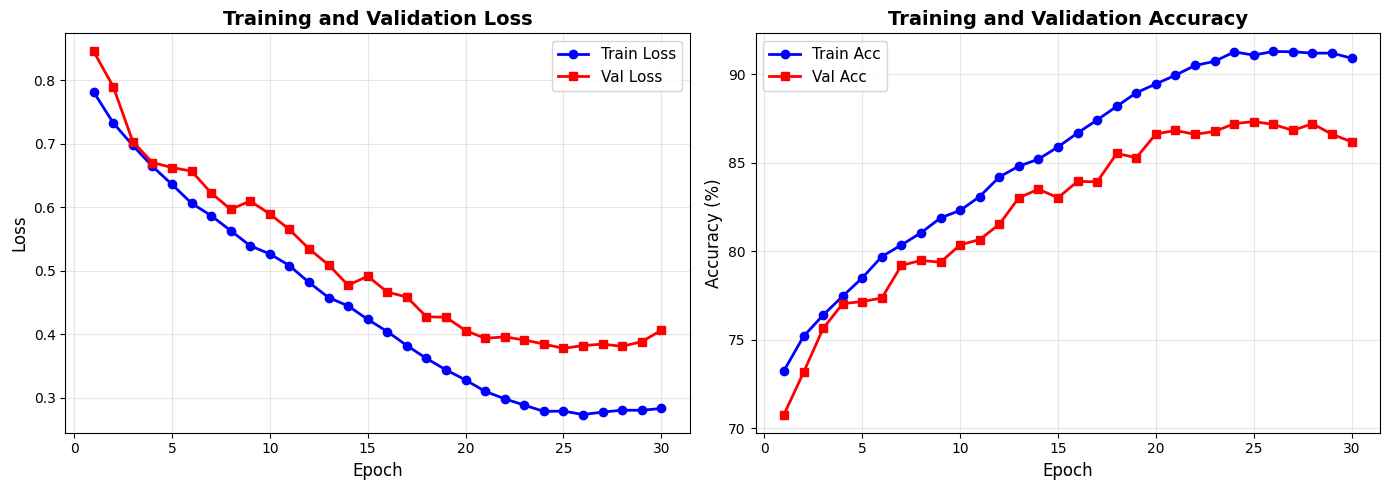

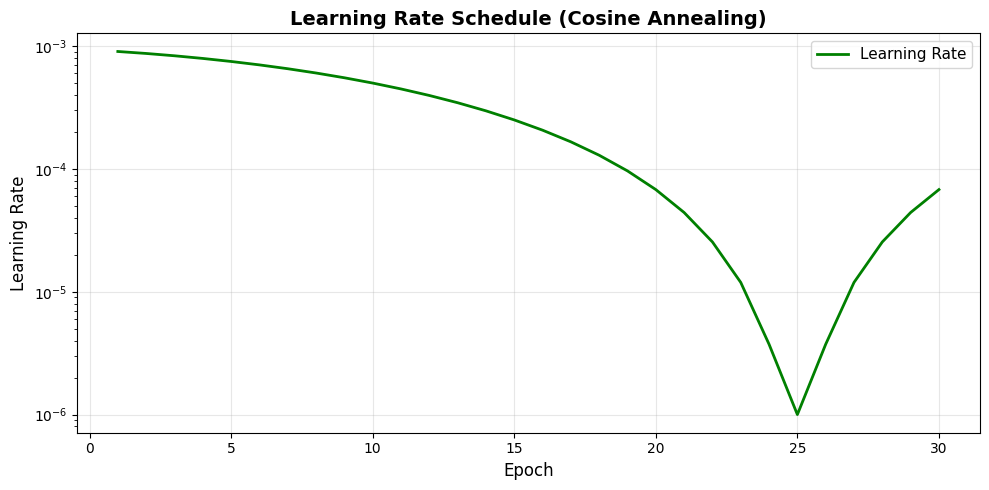

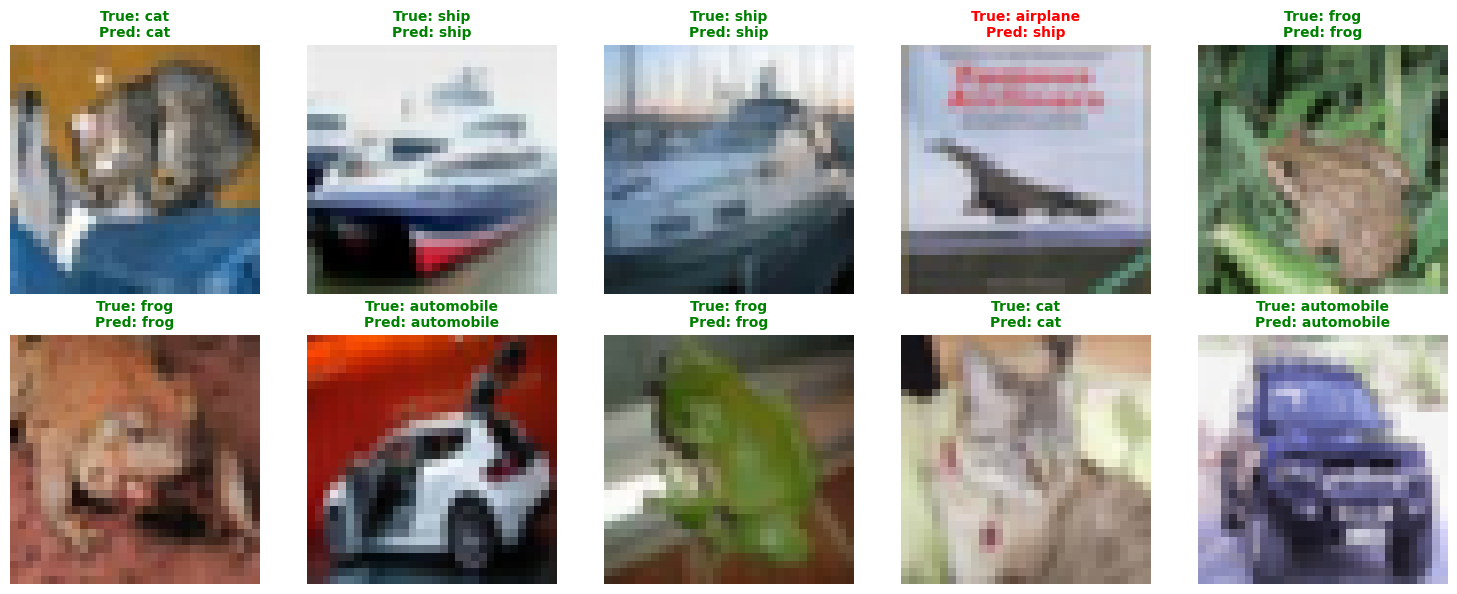

FINAL METRICS SUMMARY - PART B
Training time: 15.27 minutes (0.25 hours)
Best epoch: 25/30
Best validation accuracy: 87.32%
Final test accuracy: 86.88%
Hyperparameters:
  - Epochs: 30
  - Batch size: 256
  - Learning rate: 0.001 (with Cosine Annealing)
  - Weight decay: 0.0005
  - Dropout: 0.5



In [15]:
print("\n" + "="*70)
print("CIFAR-10 CNN TRAINING PIPELINE - PART B (FULL TRAINING)")
print("="*70)

# Initial evaluation
print("\nInitial performance (before training):")
eval(val_loader, net_model, "Validation")

# Train with history tracking
history, best_val_acc, best_epoch, total_time = train_with_history(
    net_model, train_loader, val_loader, optimizer, scheduler, n_epochs, scaler
)

# Final test evaluation
test_loss, test_acc = eval(test_loader, net_model, "Test")

# Plot training curves
plot_training_curves(history)

# Plot learning rate schedule, to monitor learning rate
plot_learning_rate(history)

# Show example predictions
show_predictions(net_model, test_loader, device)

# Final summary
print(f"{'='*70}")
print("FINAL METRICS SUMMARY - PART B")
print(f"{'='*70}")
print(f"Training time: {total_time/60:.2f} minutes ({total_time/3600:.2f} hours)")
print(f"Best epoch: {best_epoch}/{n_epochs}")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Final test accuracy: {test_acc:.2f}%")
# print(f"Total parameters: {total_params:,}")
print(f"Hyperparameters:")
print(f"  - Epochs: {n_epochs}")
print(f"  - Batch size: {batch_size}")
print(f"  - Learning rate: {learning_rate} (with Cosine Annealing)")
print(f"  - Weight decay: {weight_decay}")
print(f"  - Dropout: 0.5")
print(f"{'='*70}\n")

3. **Fair comparison to A2 (fully connected):**
- Re run (or reuse) your A2 MLP with the same data split and similar epoch budget.
- Report accuracy, loss, and at least one calibration/uncertainty proxy (e.g., confidence histograms or softmax max prob distribution).
- Briefly discuss: Why does the CNN outperform (or not)? Tie to spatial bias, parameter efficiency, and augmentation.


In [16]:
class FFNN(nn.Module):
    def __init__(self, hidden=512):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, hidden)      # 3072 -> hidden
        self.fc2 = nn.Linear(hidden, hidden//2)    # hidden -> hidden/2
        self.fc3 = nn.Linear(hidden//2, 10)        # hidden/2 -> 10 classes
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.flatten(x)         # [B, 3, 32, 32] -> [B, 3072]
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


model = FFNN(hidden=512).to(device)

criterion = nn.CrossEntropyLoss()
import torch.optim as optim
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ----- Track metrics -----
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 30 # Keeping the epoch count same
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ----- Validation -----
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/30, Train Loss: 1.9340, Train Acc: 29.74%, Val Loss: 1.7646, Val Acc: 35.50%
Epoch 2/30, Train Loss: 1.8139, Train Acc: 34.35%, Val Loss: 1.7352, Val Acc: 36.70%
Epoch 3/30, Train Loss: 1.7702, Train Acc: 36.52%, Val Loss: 1.6770, Val Acc: 38.32%
Epoch 4/30, Train Loss: 1.7367, Train Acc: 37.67%, Val Loss: 1.6544, Val Acc: 41.56%
Epoch 5/30, Train Loss: 1.7138, Train Acc: 38.62%, Val Loss: 1.6572, Val Acc: 40.94%
Epoch 6/30, Train Loss: 1.6948, Train Acc: 39.40%, Val Loss: 1.6115, Val Acc: 42.12%
Epoch 7/30, Train Loss: 1.6818, Train Acc: 39.72%, Val Loss: 1.5920, Val Acc: 43.56%
Epoch 8/30, Train Loss: 1.6728, Train Acc: 40.11%, Val Loss: 1.6098, Val Acc: 42.46%
Epoch 9/30, Train Loss: 1.6644, Train Acc: 40.27%, Val Loss: 1.5816, Val Acc: 43.08%
Epoch 10/30, Train Loss: 1.6609, Train Acc: 40.44%, Val Loss: 1.5842, Val Acc: 42.42%
Epoch 11/30, Train Loss: 1.6570, Train Acc: 40.38%, Val Loss: 1.5669, Val Acc: 43.94%
Epoch 12/30, Train Loss: 1.6387, Train Acc: 41.35%, Val Loss: 1

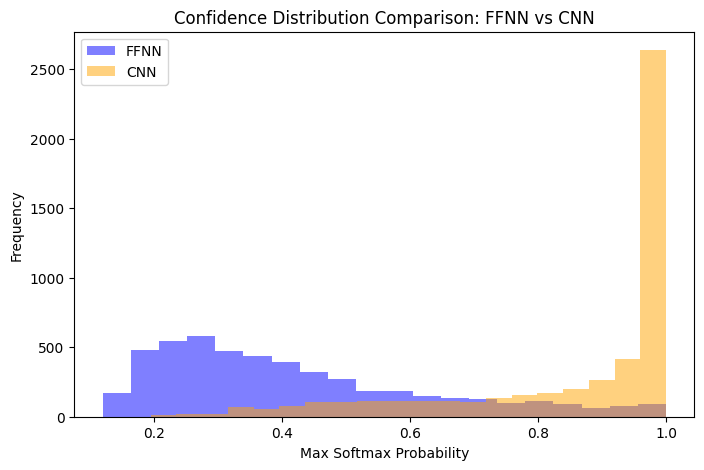

In [21]:
def get_max_probs(model, loader):
    model.eval()
    all_max_probs = []
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            outputs = model(data)
            probs = F.softmax(outputs, dim=1)
            max_probs, _ = probs.max(dim=1)
            all_max_probs.extend(max_probs.cpu().numpy())
    return all_max_probs

# Compute max softmax probabilities for both models
ffnn_probs = get_max_probs(model, val_loader)
cnn_probs = get_max_probs(net_model, val_loader)

# Plot overlaid histogram
plt.figure(figsize=(8,5))
plt.hist(ffnn_probs, bins=20, alpha=0.5, label='FFNN', color='blue')
plt.hist(cnn_probs, bins=20, alpha=0.5, label='CNN', color='orange')
plt.xlabel('Max Softmax Probability')
plt.ylabel('Frequency')
plt.title('Confidence Distribution Comparison: FFNN vs CNN')
plt.legend()
plt.show()


---
**Deliverables checklist:**
- Part A subset run with curves &amp; quick notes
- Part B full run with ≥2 augmentations
- Comparison table vs A2 (MLP)
- 3-page PDF report with plots &amp; examples
- Repro instructions + seeds

### Deadline for take‑home is **one week** after your lab session.